In [101]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [102]:
resumes = pd.read_csv('../data/resumes/Resume/Resume.csv')
resumes.head()

,ID,Resume_str,Resume_html,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR


In [103]:
from nltk.stem import WordNetLemmatizer
import re

SEED = 1

nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
    return text

resumes['Resume_str'] = resumes['Resume_str'].apply(clean_text)

X = resumes['Resume_str']
y = resumes['Category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

vectorizer = TfidfVectorizer(ngram_range=(1,5), stop_words=stopwords.words('english'), max_features=10000)
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [104]:
xgb_classifier = GradientBoostingClassifier(n_estimators=100, random_state=SEED, verbose=2)
xgb_classifier.fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1           1.7083           20.11m
         2           1.3912           20.11m
         3           1.1752           19.98m
         4           1.0008           19.79m
         5           0.8636           19.60m
         6           0.7425           19.44m
         7           0.6498           19.26m
         8           0.5673           19.05m
         9           0.4987           18.83m
        10           0.4473           18.63m
        11           0.4045           18.42m
        12           0.3655           18.20m
        13           0.3339           17.97m
        14           0.3071           17.75m
        15           0.2844           17.52m
        16           0.2639           17.30m
        17           0.2461           17.08m
        18           0.2304           16.86m
        19           0.2163           16.65m
        20           0.2035           16.44m
        21           0.1933           16.24m
        2

GradientBoostingClassifier(random_state=1, verbose=2)

In [105]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import log_loss
from sklearn.preprocessing import LabelEncoder

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

le = LabelEncoder()
le.fit(y_test)

encoded_y_train = le.transform(y_train)
encoded_y_test = le.transform(y_test)

for y_train_pred, y_test_pred in zip(xgb_classifier.staged_predict_proba(X_train), xgb_classifier.staged_predict_proba(X_test)):
    train_loss = log_loss(y_train, y_train_pred)
    test_loss = log_loss(y_test, y_test_pred)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    
    train_accuracy = accuracy_score(encoded_y_train, np.argmax(y_train_pred, axis=1))
    test_accuracy = accuracy_score(encoded_y_test, np.argmax(y_test_pred, axis=1))
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

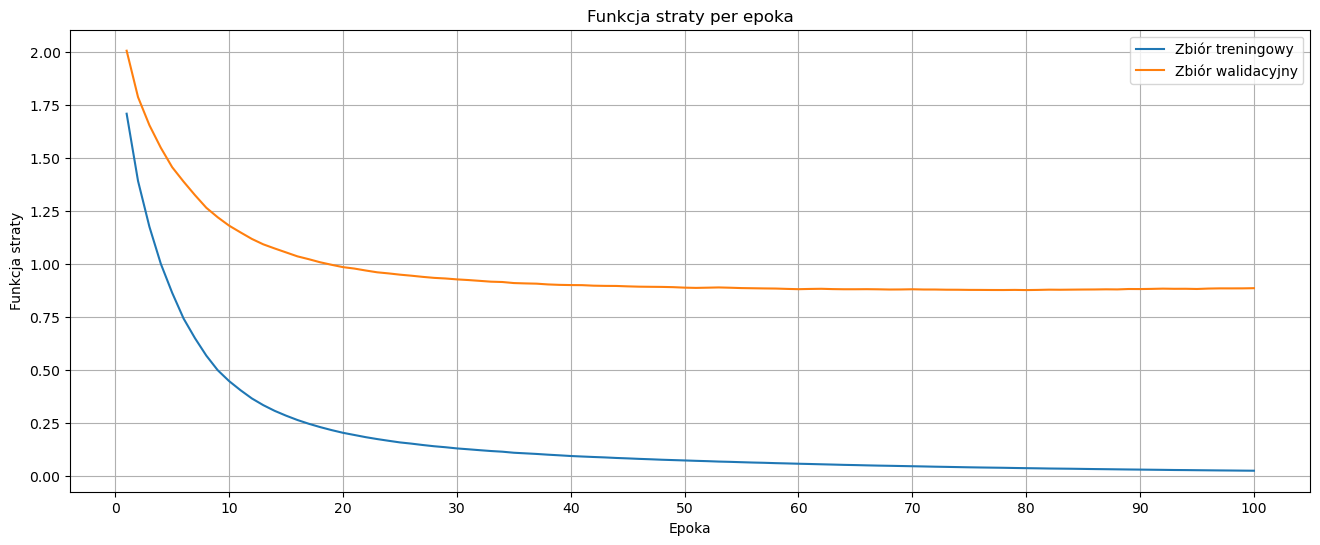

In [113]:
plt.figure(figsize=(16, 6))
plt.plot(np.arange(1, len(train_losses) + 1), train_losses, label='Zbiór treningowy')
plt.plot(np.arange(1, len(test_losses) + 1), test_losses, label='Zbiór walidacyjny')
plt.xticks(np.arange(0, 101, step=10))
plt.title('Funkcja straty per epoka')
plt.xlabel('Epoka')
plt.ylabel('Funkcja straty')
plt.legend()
plt.grid(True)
plt.show()

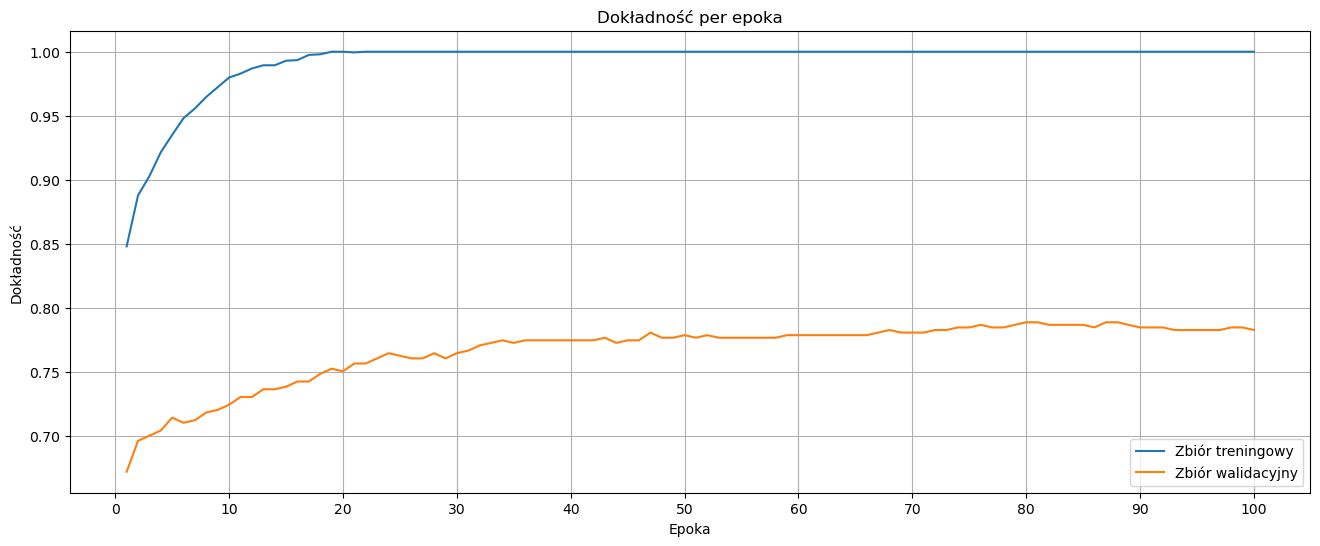

In [115]:
plt.figure(figsize=(16, 6))
plt.plot(np.arange(1, len(train_accuracies) + 1), train_accuracies, label='Zbiór treningowy')
plt.plot(np.arange(1, len(test_accuracies) + 1), test_accuracies, label='Zbiór walidacyjny')
plt.xticks(np.arange(0, 101, step=10))
plt.title('Dokładność per epoka')
plt.xlabel('Epoka')
plt.ylabel('Dokładność')
plt.legend()
plt.grid(True)
plt.show()

In [116]:
y_pred = xgb_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')
print('Classification Report:')
print(classification_report(y_test, y_pred))

Accuracy: 0.7827
Classification Report:
                        precision    recall  f1-score   support

            ACCOUNTANT       0.92      1.00      0.96        24
              ADVOCATE       0.84      0.75      0.79        28
           AGRICULTURE       0.43      0.25      0.32        12
               APPAREL       0.58      0.44      0.50        16
                  ARTS       0.50      0.81      0.62        21
            AUTOMOBILE       0.50      0.38      0.43         8
              AVIATION       1.00      0.76      0.87        17
               BANKING       0.61      0.83      0.70        23
                   BPO       1.00      0.50      0.67         4
  BUSINESS-DEVELOPMENT       0.89      0.75      0.81        32
                  CHEF       0.85      0.92      0.88        25
          CONSTRUCTION       0.92      0.96      0.94        23
            CONSULTANT       0.80      0.73      0.76        22
              DESIGNER       0.95      0.95      0.95        20

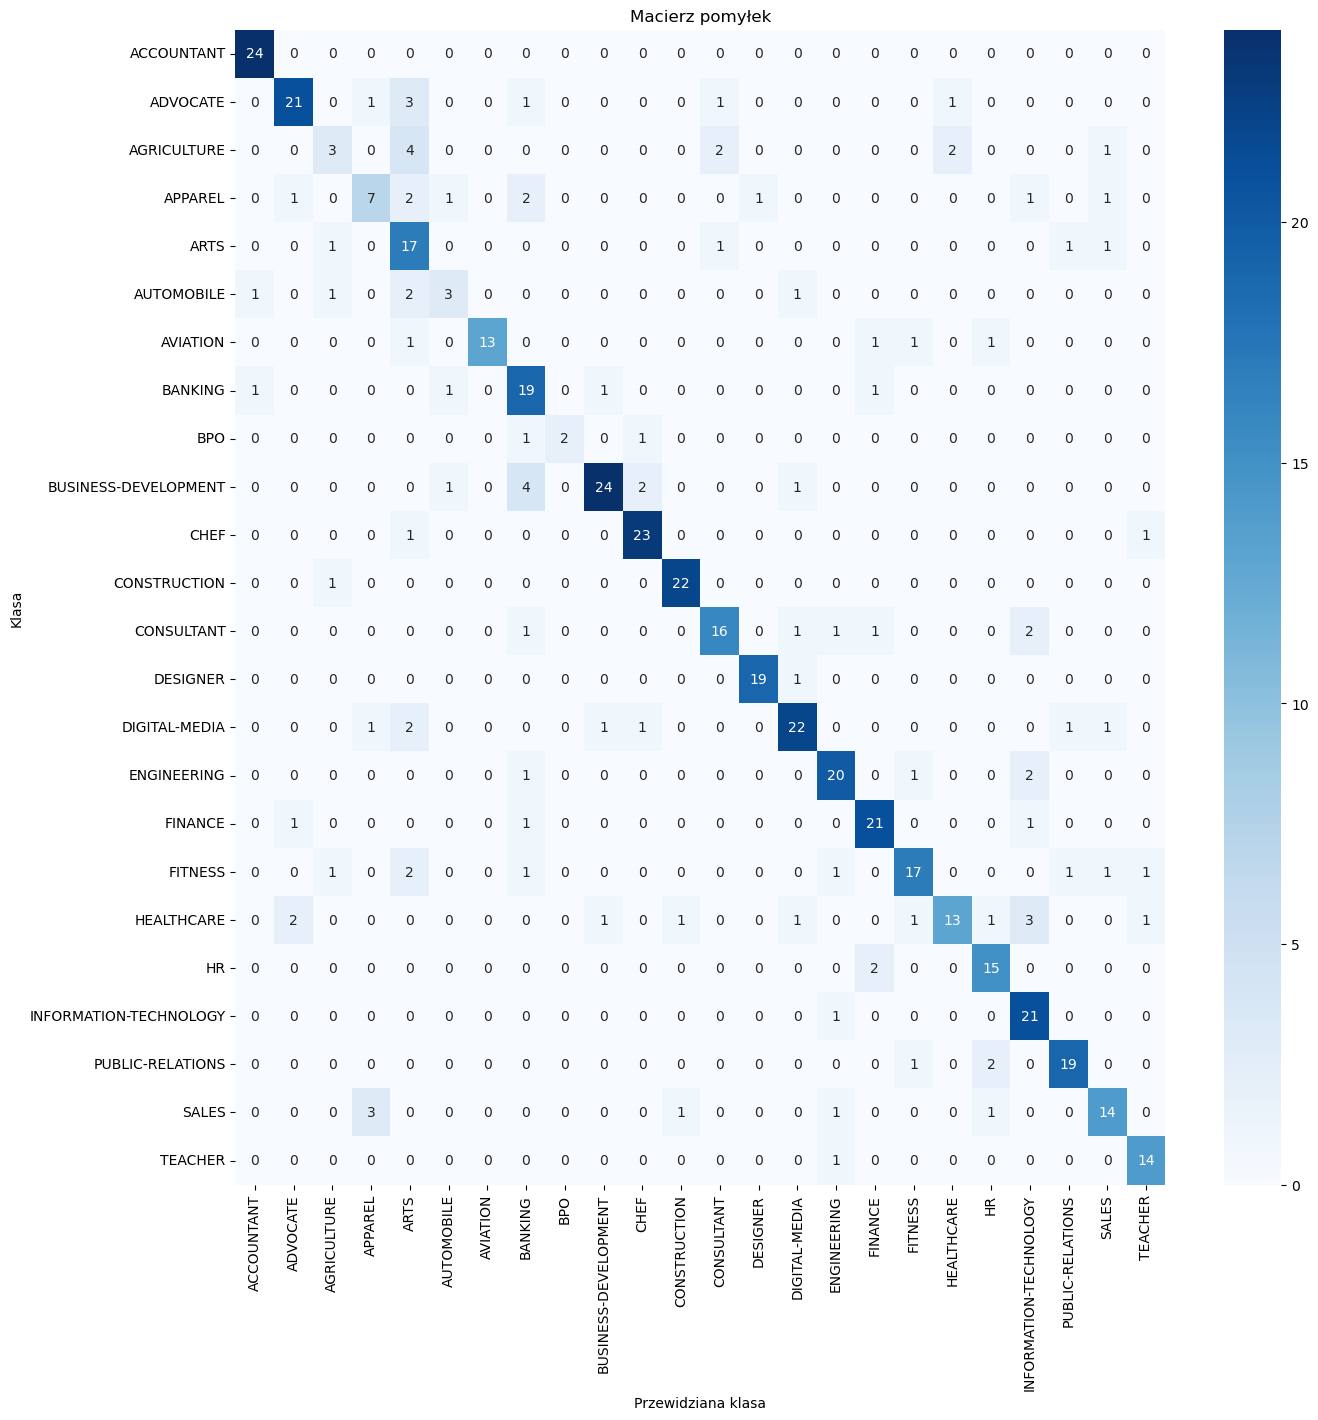

In [117]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = xgb_classifier.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(15, 15))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Macierz pomyłek')
plt.xlabel('Przewidziana klasa')
plt.ylabel('Klasa')
plt.show()

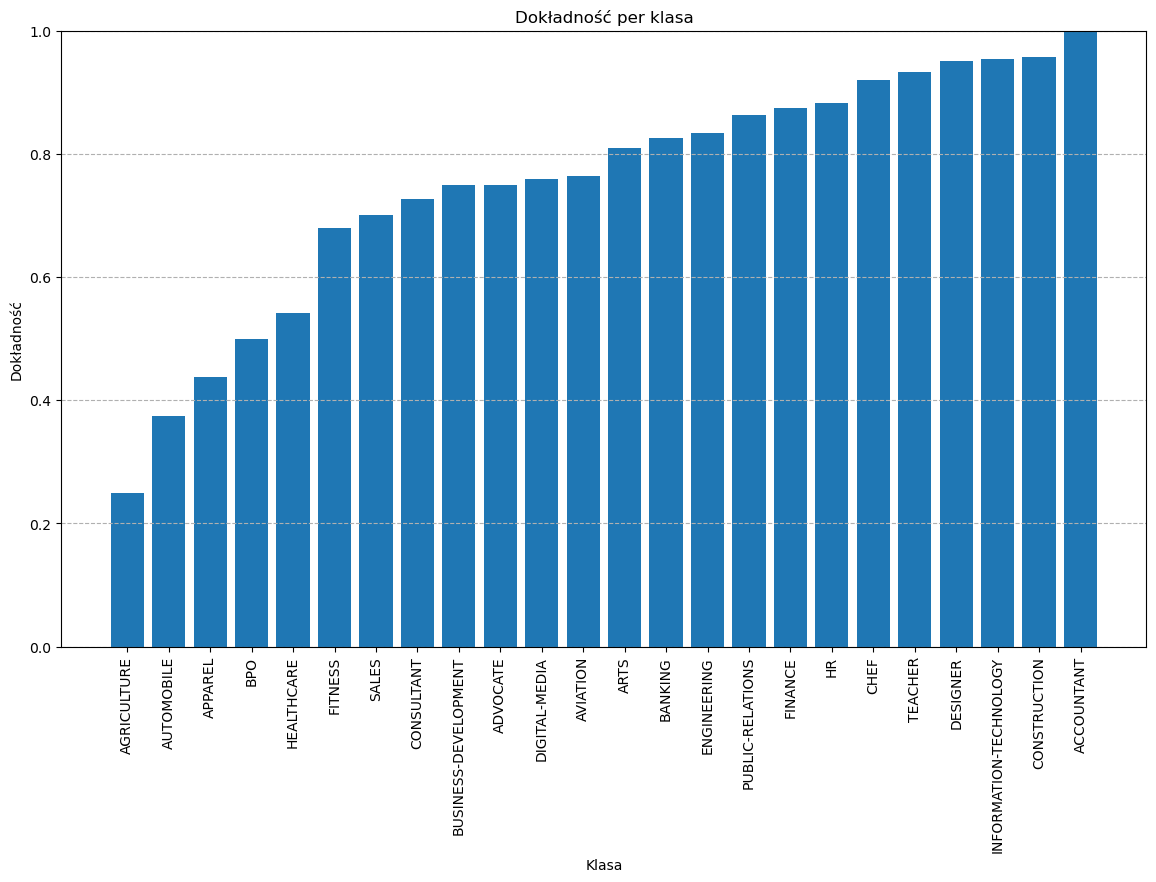

In [118]:
class_accuracies = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)

classes = le.classes_

sorted_indices = np.argsort(class_accuracies)
sorted_accuracies = class_accuracies[sorted_indices]
sorted_classes = classes[sorted_indices]

plt.figure(figsize=(14, 8))
plt.bar(sorted_classes, sorted_accuracies)
plt.xlabel('Klasa')
plt.ylabel('Dokładność')
plt.title('Dokładność per klasa')
plt.xticks(rotation=90)
plt.ylim([0, 1])
plt.grid(axis='y', linestyle='--')
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_14904\140747602.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('tab20', n_classes)


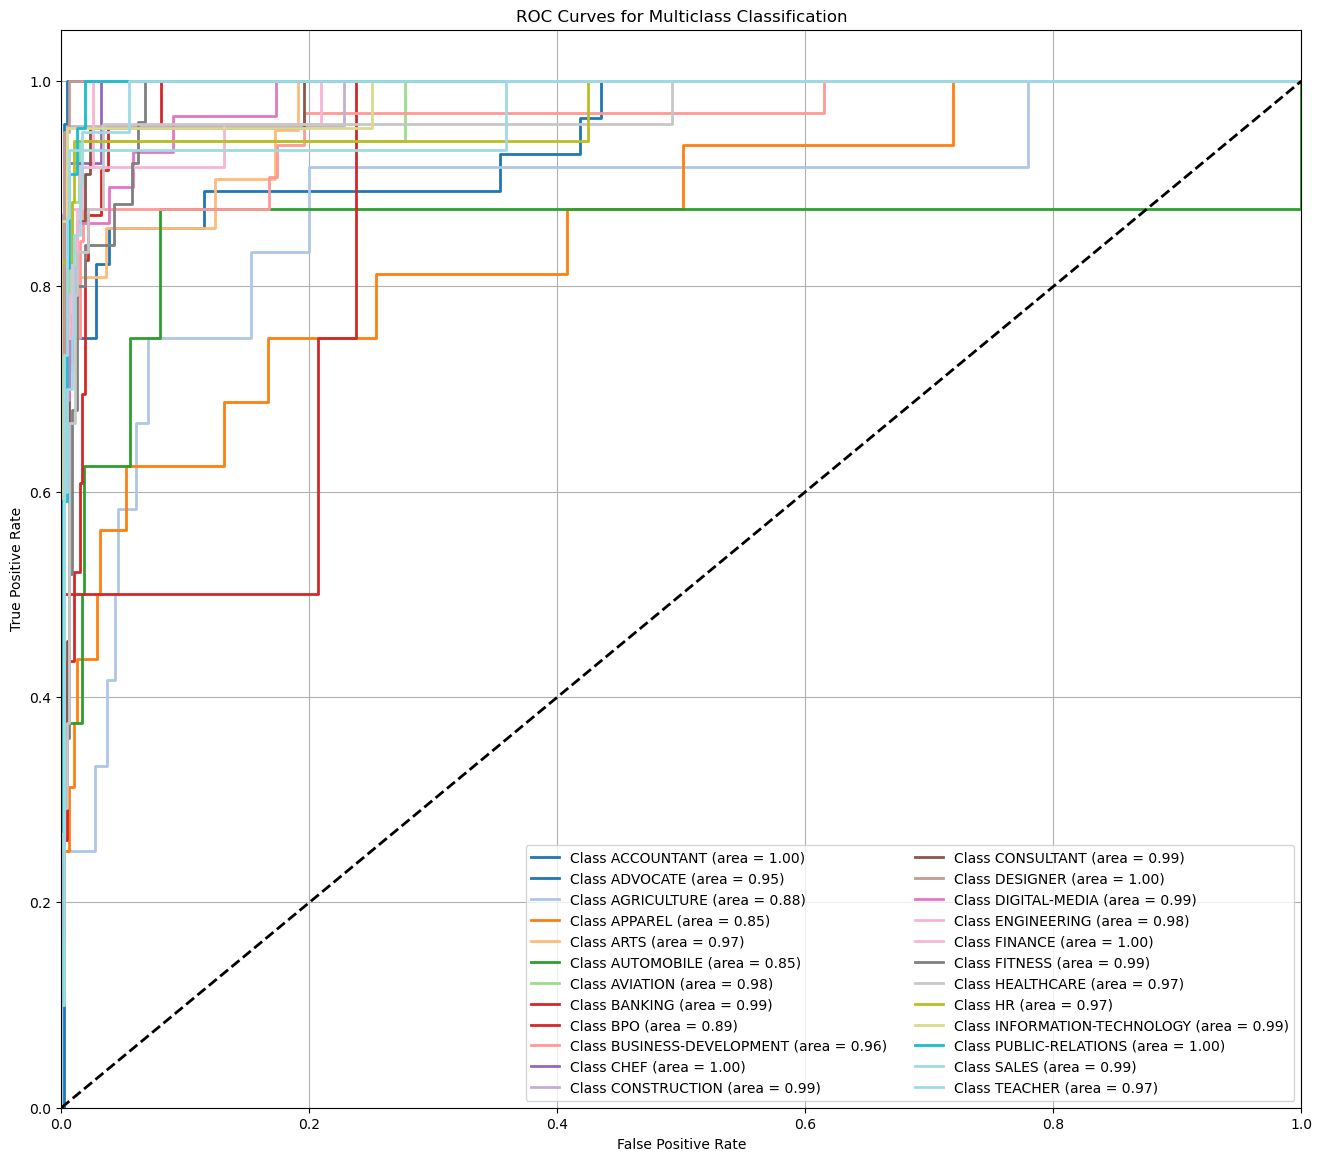

Gini Coefficient: 0.9290326186521767


In [119]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.cm as cm

n_classes = len(le.classes_)
colors = cm.get_cmap('tab20', n_classes)

y_pred_probs = xgb_classifier.predict_proba(X_test)

fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(encoded_y_test == i, y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(16, 14))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors(i), lw=2, label=f'Class {le.classes_[i]} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Odsetek fałszywie pozytywnych')
plt.ylabel('Odsetek prawdziwie pozytywnych')
plt.title('Krzywe ROC')

plt.legend(loc="lower right", bbox_to_anchor=(1, 0), ncol=2)

plt.grid(True)
plt.show()

roc_auc = roc_auc_score(encoded_y_test, y_pred_probs, multi_class='ovr')
gini = 2 * roc_auc - 1
print(f'Gini Coefficient: {gini}')